In [2]:
import catboost
from catboost import *
import shap
shap.initjs()

Test catboost with data from pandas dataframes (apparently it can directly train on dataframes with different types of info in them, so this notebook uses non-OHE data.)

## Preparing the data sets

In [3]:
import pandas

In [57]:
rxns_df = pandas.read_csv("godineau2023_reactions_with_yields.tsv", sep='\t')
rxns_df_x = rxns_df.drop("Yield of 3aa", axis = 1)
rxns_df_x = rxns_df_x.drop("Conversion of 1a", axis = 1)
rxns_df_x_train = rxns_df_x.copy()
rxns_df_x_valid = rxns_df_x.copy()
rxns_df_x_test = rxns_df_x.copy()

for i in range(0, len(rxns_df_x_train["Round"])):
    if rxns_df_x_train["Round"][i] > 8:
        rxns_df_x_train.drop(i, inplace = True)
print(rxns_df_x_train)

for i in range(0, len(rxns_df_x_valid["Round"])):
    if rxns_df_x_valid["Round"][i] != 9:
        rxns_df_x_valid.drop(i, inplace = True)
print(rxns_df_x_valid)

for i in range(0, len(rxns_df_x_test["Round"])):
    if rxns_df_x_test["Round"][i] != 10:
        rxns_df_x_test.drop(i, inplace = True)
print(rxns_df_x_test)

    Cu source Ligand  Ligand equiv.    Base  Base equiv. Solvent  Molarity  \
0    Cu(OAc)2     L5           0.05  Cs2CO3          2.0    PhMe       0.5   
1    Cu(OAc)2     L8           0.05  Cs2CO3          2.0    PhMe       1.0   
2    Cu(OAc)2    L10           0.05    Et3N          1.0    EtOH       0.5   
3        Cu2O     L3           0.10    TBAO          2.0    EtOH       1.0   
4        CuBr     L5           0.10  NaOtBu          0.5    PhMe       1.0   
..        ...    ...            ...     ...          ...     ...       ...   
243  Cu(OAc)2    L10           0.05   K3PO4          0.5     ACN       1.0   
244       CuI     L8           0.10   K2CO3          2.0    PhMe       0.5   
245      Cu2O     L7           0.10   K2CO3          0.5    DMSO       1.0   
246       CuI     L5           0.10  NaOtBu          2.0   iBuOH       0.5   
247      CuBr    L11           0.05   NaOAc          1.0    PhMe       0.5   

     T [°C]  BnNH2 equiv.  Round Acquisition type  
0        60

In [5]:
rxns_df_y = rxns_df[["Yield of 3aa","Round"]]
print(rxns_df_y)

     Yield of 3aa  Round
0            0.00      0
1            0.00      0
2            0.00      0
3           20.63      0
4            0.00      0
..            ...    ...
259          3.73     10
260          1.18     10
261          0.00     10
262          0.45     10
263          4.74     10

[264 rows x 2 columns]


In [6]:
rxns_df_y_train = rxns_df_y.copy()
rxns_df_y_valid = rxns_df_y.copy()
rxns_df_y_test = rxns_df_y.copy()

for i in range(0, len(rxns_df_y_train["Round"])):
    if rxns_df_y_train["Round"][i] > 8:
        rxns_df_y_train.drop(i, inplace = True)
print(rxns_df_y_train)

for i in range(0, len(rxns_df_y_valid["Round"])):
    if rxns_df_y_valid["Round"][i] != 9:
        rxns_df_y_valid.drop(i, inplace = True)
print(rxns_df_y_valid)

for i in range(0, len(rxns_df_y_test["Round"])):
    if rxns_df_y_test["Round"][i] != 10:
        rxns_df_y_test.drop(i, inplace = True)
print(rxns_df_y_test)

     Yield of 3aa  Round
0            0.00      0
1            0.00      0
2            0.00      0
3           20.63      0
4            0.00      0
..            ...    ...
243         49.85      8
244         26.13      8
245         59.25      8
246          0.77      8
247         10.72      8

[216 rows x 2 columns]
     Yield of 3aa  Round
72          16.24      9
73          32.51      9
74           6.41      9
75           1.21      9
76           5.57      9
77           9.61      9
78           1.43      9
79           4.97      9
160          4.10      9
161          8.07      9
162         67.93      9
163          7.01      9
164         13.96      9
165         87.20      9
166         74.88      9
167         26.63      9
248         63.53      9
249         45.67      9
250         42.19      9
251         61.66      9
252          8.41      9
253          0.00      9
254         43.53      9
255         10.83      9
     Yield of 3aa  Round
80          34.54     10
8

In [7]:
rxns_df_y_train = rxns_df_y_train[["Yield of 3aa"]]
rxns_df_y_valid = rxns_df_y_valid[["Yield of 3aa"]]
rxns_df_y_test = rxns_df_y_test[["Yield of 3aa"]]
rxns_df_y = rxns_df_y[['Yield of 3aa']]

## Testing CatBoost - Manual separation of sets

In [58]:
from catboost import CatBoostClassifier
import sklearn
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import r2_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
import numpy as np

In [59]:
#training
numerical_features = rxns_df_x_train.select_dtypes(include=['int','float']).columns
categorical_features = rxns_df_x_train.select_dtypes(include=['object']).columns
label_encoders={}
for feature in categorical_features:
    label_encoders[feature]=LabelEncoder()
    rxns_df_x_train[feature] = label_encoders[feature].fit_transform(rxns_df_x_train[feature])
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(rxns_df_x_train, rxns_df_y_train, verbose=False,plot=False)

#validation
numerical_features = rxns_df_x_valid.select_dtypes(include=['int','float']).columns
categorical_features = rxns_df_x_valid.select_dtypes(include=['object']).columns
label_encoders={}
for feature in categorical_features:
    label_encoders[feature]=LabelEncoder()
    rxns_df_x_valid[feature] = label_encoders[feature].fit_transform(rxns_df_x_valid[feature])
rxns_df_y_pred = model.predict(rxns_df_x_valid)
accuracy = r2_score(rxns_df_y_valid, rxns_df_y_pred)
#accuracy = model.score(rxns_df_y_pred, rxns_df_y_valid)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_valid = mean_absolute_error(rxns_df_y_valid, rxns_df_y_pred)
RMSE_valid = np.sqrt(mean_squared_error(rxns_df_y_valid, rxns_df_y_pred))
print(f"Validation RMSE:{RMSE_valid}")
print(f'Validation MAE:{MAE_valid}')

#feature importance
feature_importance = model.get_feature_importance()
print("Feature Importance:")
for feature, importance in zip(rxns_df_x_train.columns, feature_importance):
    print(f"{feature}:{importance}")

#testing
numerical_features = rxns_df_x_test.select_dtypes(include=['int','float']).columns
categorical_features = rxns_df_x_test.select_dtypes(include=['object']).columns
label_encoders={}
for feature in categorical_features:
    label_encoders[feature]=LabelEncoder()
    rxns_df_x_test[feature] = label_encoders[feature].fit_transform(rxns_df_x_test[feature])
rxns_df_y_test_pred = model.predict(rxns_df_x_test)
#accuracy_test = model.score(rxns_df_y_test_pred, rxns_df_y_test)
accuracy_test = r2_score(rxns_df_y_test, rxns_df_y_test_pred)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(rxns_df_y_test, rxns_df_y_test_pred)
RMSE_test = np.sqrt(mean_squared_error(rxns_df_y_test, rxns_df_y_test_pred))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.5168022368117644
Validation RMSE:18.44803163229693
Validation MAE:15.282676152539251
Feature Importance:
Cu source:7.868128039336437
Ligand:11.566157512955261
Ligand equiv.:2.1515989817973837
Base:30.91514863521468
Base equiv.:3.861742831412748
Solvent:13.348953673073268
Molarity:2.865896946807692
T [°C]:4.924542853137339
BnNH2 equiv.:2.6789718311841155
Round:13.031569470676653
Acquisition type:6.787289224404441
Test Set Accuracy with r2 : 0.5468355703419616
Test RMSE:19.751072302678867
Test MAE:15.422080182055007


With CatBoostRegressor, the accuracy is higher and RMSE and MAE are lower than with CatBoostClassifier

In [60]:
#use SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(rxns_df_x_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], rxns_df_x_train.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [61]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, rxns_df_x_train)

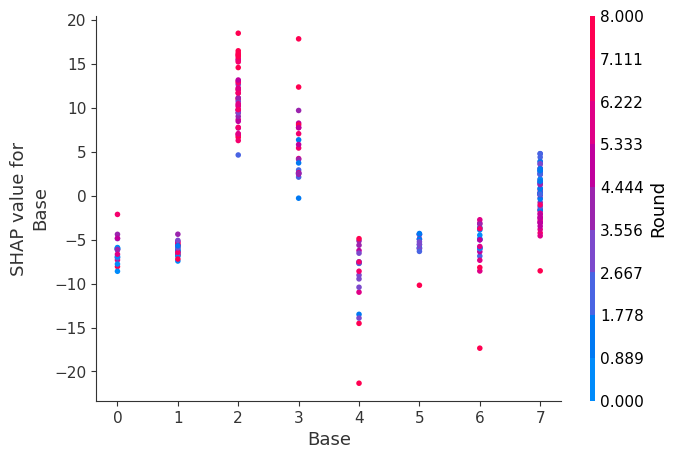

In [62]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Base", shap_values, rxns_df_x_train)

Bases 2 and 3 show the highest yields : expected as they correspond to K2CO3 and K3PO4

Indexing of bases :
- 0 : Cs2CO3
- 1 : Et3N
- 2 : K2CO3
- 3 : K3PO4
- 4 : KOH
- 5 : NaOAc
- 6 : NaOtBu
- 7 : TBAO 

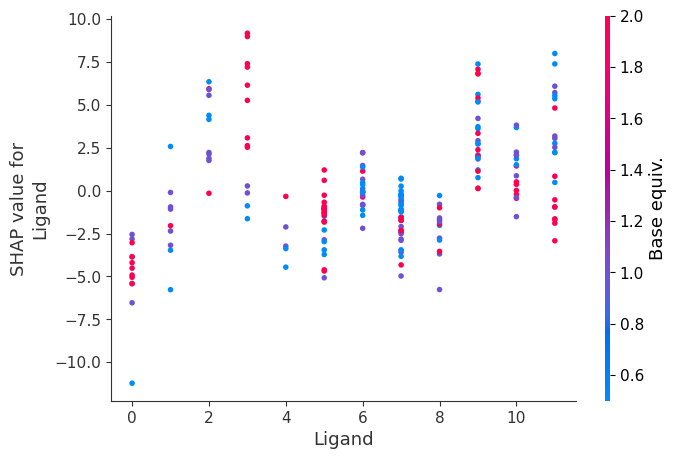

In [72]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Ligand", shap_values, rxns_df_x_train)

This indicates that L12, L7 and L9 seem to lead to the highest yields. This is in agreement with data_exploration.ipynb. Note that the highest yield is shown here to be obtained with L12 for rounds 1 through 8.

Indexing of ligands :
- L1 : 0
- L2 : 4
- L3 : 5
- L4 : 6
- L5 : 7
- L6 : 8
- L7 : 9
- L8 : 10
- L9 : 11
- L10 : 1
- L11 : 2
- L12 : 3

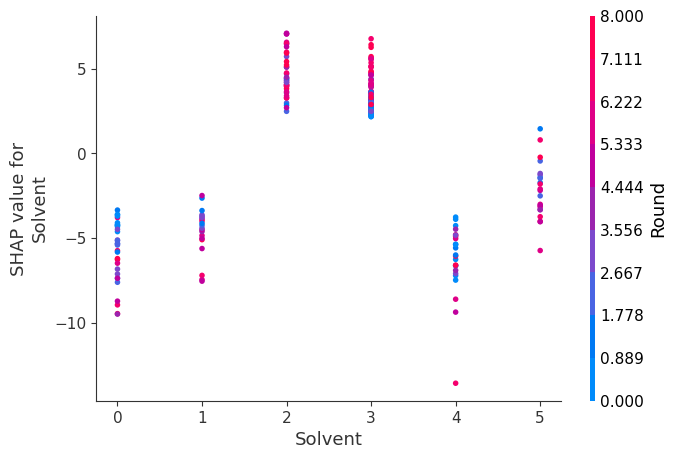

In [73]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Solvent", shap_values, rxns_df_x_train)

Using DMSO and EtOH consistently leads to higher yields.

Indexing of solvents :
- 0 : 2Me-THF
- 1 : ACN
- 2 : DMSO
- 3 : EtOH
- 4 : PhMe
- 5 : iBuOH

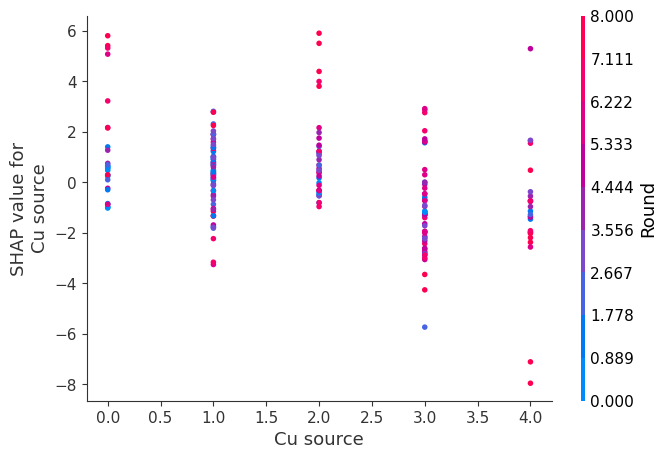

In [80]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Cu source", shap_values, rxns_df_x_train)

Cu(OAc)2 and CuBr lead to the highest yields here. This is in accordance with data_exploration.ipynb.

Indexing of Cu sources :
- 0 : Cu(OAc)2
- 1 : Cu2O
- 2 : CuBr
- 3 : CuCl
- 4 : CuI

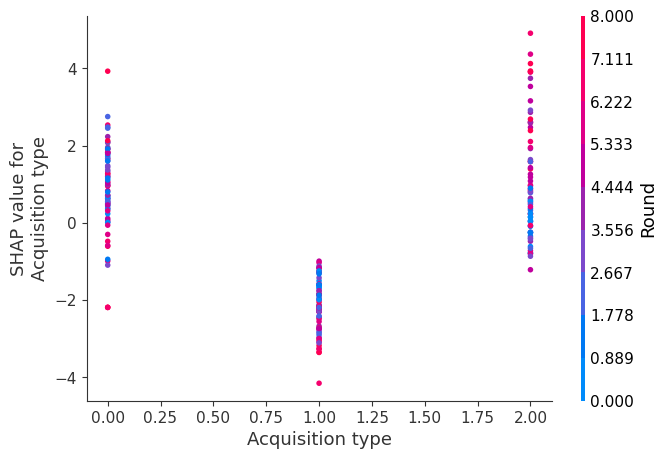

In [74]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Acquisition type", shap_values, rxns_df_x_train)

Interestingly, for the training sample, EI leads to the lowest yields. However we know that in further rounds it leads to the highest yield obtained in this experiment. Somehow this makes sense: EI stands for Expected Improvement which is why its starting yields are low and improve through the experiment.

Indexing of acquisition types
- 0 : TS
- 1 : EI
- 2 : UCB

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


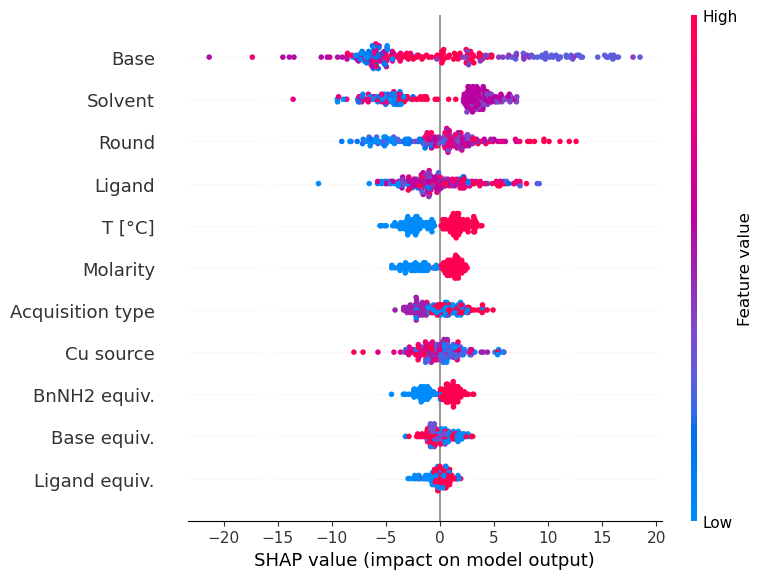

In [31]:
# summarize the effects of all the features
shap.summary_plot(shap_values, rxns_df_x_train)

Main takeways:
- The choice of the base has the highest impact on the yield of the reaction (followed by the Round, Solvent and Ligand)
- We can identify that the redder the point in the Round faction, the higher the round (as in round 10 will show higher yields than round 1)
- Notice the temperature only has two feature values as expected : the one shown in red (higher value = 80°C) makes the yield higher and the one shown in blue (lower value = 60°C) makes the yield lower.
- Refer to data_exploration.ipynb : We can recognize the lone blue point showing the lowest yield as being an experiment using one of the first ligands (i.e. L1, L2 or other) which as we saw tended to give low yields in comparison the L7, L8, L9. The extra purple-ish points on the higher yield side correspond to L10, L11, L12
- Refer to data_exploration.ipynb : We had identified K2CO3 and K3PO4 as the bases leading to the highest yields and the graph above is in accordance with this observation (notice the blue/purple dots on the highers side corresponding to bases 2 and 3 : K2CO3 and K3PO4)

In [35]:
#back to CatBoostClassifier for this part 
#training
numerical_features = rxns_df_x_train.select_dtypes(include=['int','float']).columns
categorical_features = rxns_df_x_train.select_dtypes(include=['object']).columns
label_encoders={}
for feature in categorical_features:
    label_encoders[feature]=LabelEncoder()
    rxns_df_x_train[feature] = label_encoders[feature].fit_transform(rxns_df_x_train[feature])
cat_features=[rxns_df_x_train.get_loc(col) for col in categorical_features]
model = CatBoostClassifier(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(rxns_df_x_train, rxns_df_y_train, cat_features=cat_features,verbose=False, plot=False)

#validation
numerical_features = rxns_df_x_valid.select_dtypes(include=['int','float']).columns
categorical_features = rxns_df_x_valid.select_dtypes(include=['object']).columns
label_encoders={}
for feature in categorical_features:
    label_encoders[feature]=LabelEncoder()
    rxns_df_x_valid[feature] = label_encoders[feature].fit_transform(rxns_df_x_valid[feature])
rxns_df_y_pred = model.predict(rxns_df_x_valid)
accuracy = r2_score(rxns_df_y_valid, rxns_df_y_pred)
#accuracy = model.score(rxns_df_y_pred, rxns_df_y_valid)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_valid = mean_absolute_error(rxns_df_y_valid, rxns_df_y_pred)
RMSE_valid = np.sqrt(mean_squared_error(rxns_df_y_valid, rxns_df_y_pred))
print(f"Validation RMSE:{RMSE_valid}")
print(f'Validation MAE:{MAE_valid}')

#feature importance
feature_importance = model.get_feature_importance()
print("Feature Importance:")
for feature, importance in zip(rxns_df_x_train.columns, feature_importance):
    print(f"{feature}:{importance}")

#testing
numerical_features = rxns_df_x_test.select_dtypes(include=['int','float']).columns
categorical_features = rxns_df_x_test.select_dtypes(include=['object']).columns
label_encoders={}
for feature in categorical_features:
    label_encoders[feature]=LabelEncoder()
    rxns_df_x_test[feature] = label_encoders[feature].fit_transform(rxns_df_x_test[feature])
rxns_df_y_test_pred = model.predict(rxns_df_x_test)
#accuracy_test = model.score(rxns_df_y_test_pred, rxns_df_y_test)
accuracy_test = r2_score(rxns_df_y_test, rxns_df_y_test_pred)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(rxns_df_y_test, rxns_df_y_test_pred)
RMSE_test = np.sqrt(mean_squared_error(rxns_df_y_test, rxns_df_y_test_pred))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :-0.6592501069528252
Validation RMSE:34.18562341537872
Validation MAE:22.919583635727566
Feature Importance:
Cu source:11.537781240081372
Ligand:10.568641641398111
Ligand equiv.:6.47365002860118
Base:11.80985437190902
Base equiv.:13.22116191793303
Solvent:8.871084678470641
Molarity:6.351557598441365
T [°C]:6.2484722906597625
BnNH2 equiv.:6.603719145871748
Round:11.048123656378658
Acquisition type:7.265953430255105
Test Set Accuracy with r2 : -0.2624778227723885
Test RMSE:32.96663738096075
Test MAE:23.88916661163171


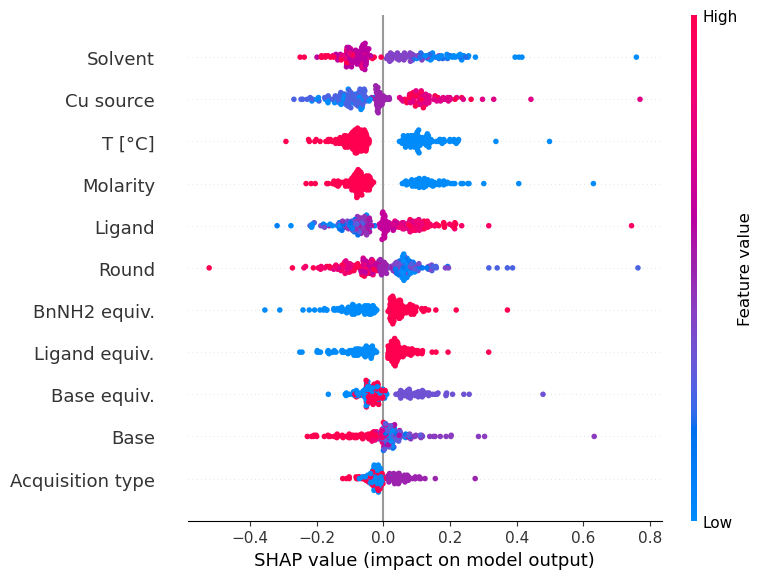

In [38]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(rxns_df_x_train, rxns_df_y_train, cat_features=cat_features))
shap.summary_plot(shap_values[1], rxns_df_x_train)

Doesn't make a lot of sense for a lower round to give a higher yield (in general). CatBoostClassifier is definitely not suited for this task.

## Testing CatBoost - Using train_test_split()

In [40]:
#training
#prepping x
numerical_features = rxns_df_x.select_dtypes(include=['int','float']).columns
categorical_features = rxns_df_x.select_dtypes(include=['object']).columns
label_encoders={}
for feature in categorical_features:
    label_encoders[feature]=LabelEncoder()
    rxns_df_x[feature] = label_encoders[feature].fit_transform(rxns_df_x[feature])
#prepping y
numerical_features_y = rxns_df_y.select_dtypes(include=['int','float']).columns
categorical_features_y = rxns_df_y.select_dtypes(include=['object']).columns
label_encoders_y={}
for feature in categorical_features_y:
    label_encoders[feature]=LabelEncoder()
    rxns_df_y[feature] = label_encoders_y[feature].fit_transform(rxns_df_y[feature])
x_train, x_temp, y_train, y_temp = train_test_split(rxns_df_x, rxns_df_y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(x_train, y_train,verbose=False, plot=False)

#validation
y_val_pred = model.predict(x_val)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val, y_val_pred)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val, y_val_pred)
RMSE_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')


#feature importance
feature_importance = model.get_feature_importance()
print("Feature Importance:")
for feature, importance in zip(x_train.columns, feature_importance):
    print(f"{feature}:{importance}")

#testing
y_test_pred = model.predict(x_test)
accuracy_test = r2_score(y_test, y_test_pred)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test, y_test_pred)
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.6708064900654007
Validation RMSE:11.73029033049484
Validation MAE:8.57181057828194
Feature Importance:
Cu source:6.765397596497093
Ligand:8.003748463382033
Ligand equiv.:1.7676951031407002
Base:30.619945281664975
Base equiv.:7.116135134678959
Solvent:17.733826373060953
Molarity:1.893384413562281
T [°C]:7.992846540754872
BnNH2 equiv.:2.4825776452371096
Round:8.915071416274223
Acquisition type:6.709372031746773
Test Set Accuracy with r2 : 0.6497328633459041
Test RMSE:12.74697024017883
Test MAE:9.424181441837765


The RMSE and MAE here are lower: this model seems to be more accurate. (still valid for CatBoostRegressor!)

In [47]:
#use SHAP
explainer = shap.TreeExplainer(model)
shap_values_1 = explainer.shap_values(x_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values_1[0,:],x_train.iloc[0,:])

In [48]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values_1, x_train)

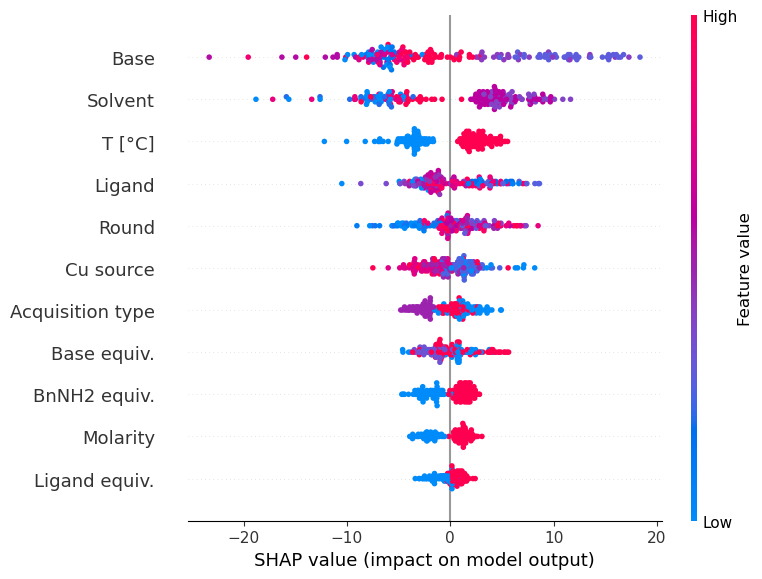

In [49]:
# summarize the effects of all the features
shap.summary_plot(shap_values_1, x_train)

The general order of importance of impact on yield of the parameters is the same as the one with the previous sample dissociation. Only really notable difference would be temperature (has a much higher impact).

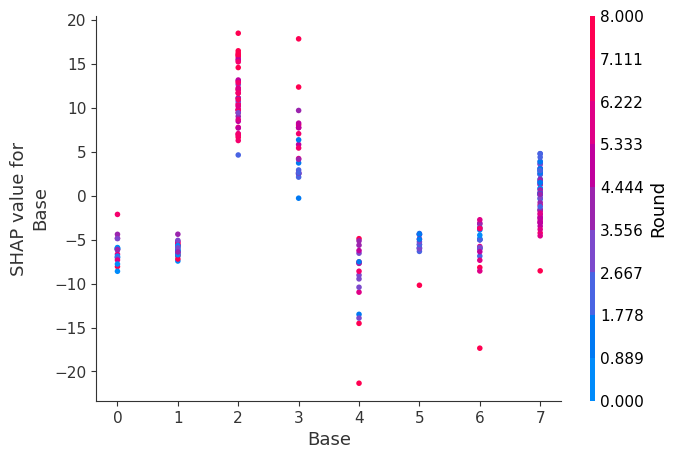

In [71]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Base", shap_values, rxns_df_x_train)

Again bases 2 and 3 lead to the highest yield